# Классификация Симпсонов

Задача состоит в том, чтобы научиться по скриншоту из телепередачи "Симпсоны" опеределять, что за персонаж изображён на нём. 



## 0. Установка зависимостей и поготовка данных

In [ ]:
'''
!pip install -U torch torchvision

# установка подходящей версии torch

from os.path import exists
#from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
#platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
!pip uninstall -y Pillow
!pip install Pillow
import PIL
print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перехгрузите данный ноутбук:
# Menu > Runtime > Restart Runtime


# Dataset from google drive:

from google.colab import drive
drive.mount('/content/gdrive/')
!unzip -q /content/gdrive/My\ Drive/journey-springfield.zip -d dataset
!unzip -q /content/gdrive/My\ Drive/simpsons/data/testset.zip -d test

'''

In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
!nvidia-smi
import torch
torch.cuda.is_available()

Wed Sep  6 17:03:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [3]:
import pickle
import numpy as np
import torch
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [4]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому приведём их к одному размеру (это делает метод  _prepare_sample) 

In [5]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [6]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [7]:
#TRAIN_DIR = Path('gdrive/MyDrive/SimpsonsDataset/train/simpsons_dataset')
#TEST_DIR = Path('gdrive/MyDrive/SimpsonsDataset/testset/testset')

TRAIN_DIR = Path('/kaggle/input/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('/kaggle/input/journey-springfield/testset/testset')
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [8]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [9]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [10]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

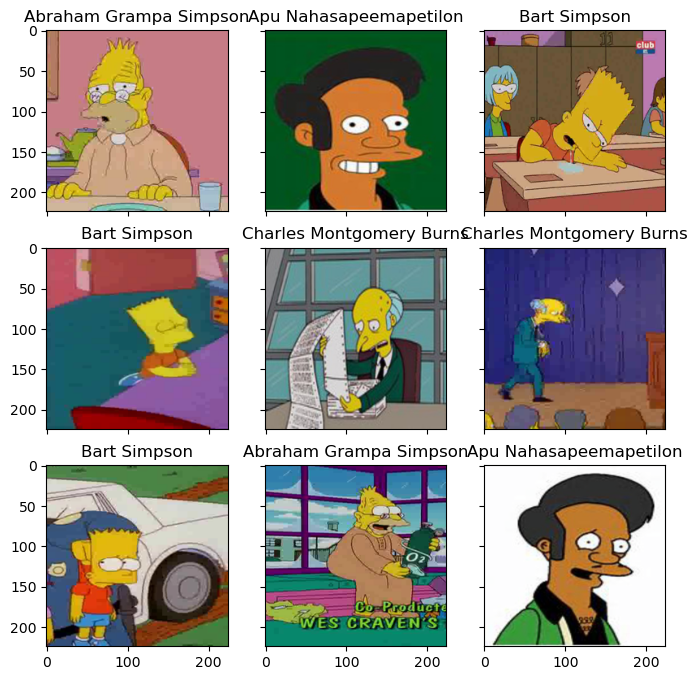

In [20]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

## 1. Baseline

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [21]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [11]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [12]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [13]:
def train(train_files, val_files, model, epochs, batch_size, lr=1e-3):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            #print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [14]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [26]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

Запустим обучение сети.

In [15]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [28]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=14, batch_size=64)

epoch:   7%|▋         | 1/14 [04:51<1:03:08, 291.40s/it]


Epoch 001 train_loss: 2.5466     val_loss 1.8972 train_acc 0.2926 val_acc 0.4796


epoch:  14%|█▍        | 2/14 [07:31<42:46, 213.91s/it]  


Epoch 002 train_loss: 1.4813     val_loss 1.2680 train_acc 0.5951 val_acc 0.6551


epoch:  21%|██▏       | 3/14 [10:11<34:44, 189.48s/it]


Epoch 003 train_loss: 0.9901     val_loss 1.0464 train_acc 0.7279 val_acc 0.7232


epoch:  29%|██▊       | 4/14 [12:47<29:22, 176.20s/it]


Epoch 004 train_loss: 0.7061     val_loss 0.9362 train_acc 0.8026 val_acc 0.7591


epoch:  43%|████▎     | 6/14 [17:58<21:54, 164.29s/it]


Epoch 006 train_loss: 0.3726     val_loss 0.9759 train_acc 0.8911 val_acc 0.7778


epoch:  50%|█████     | 7/14 [20:34<18:50, 161.47s/it]


Epoch 007 train_loss: 0.2828     val_loss 1.0384 train_acc 0.9134 val_acc 0.7810


epoch:  57%|█████▋    | 8/14 [23:10<15:58, 159.72s/it]


Epoch 008 train_loss: 0.2121     val_loss 1.0834 train_acc 0.9339 val_acc 0.7954


epoch:  64%|██████▍   | 9/14 [25:49<13:18, 159.68s/it]


Epoch 009 train_loss: 0.1507     val_loss 1.2331 train_acc 0.9501 val_acc 0.7828


epoch:  71%|███████▏  | 10/14 [28:25<10:33, 158.41s/it]


Epoch 010 train_loss: 0.1202     val_loss 1.2658 train_acc 0.9618 val_acc 0.7914


epoch:  79%|███████▊  | 11/14 [30:59<07:51, 157.26s/it]


Epoch 011 train_loss: 0.1150     val_loss 1.4186 train_acc 0.9632 val_acc 0.7799


epoch:  86%|████████▌ | 12/14 [33:39<05:15, 157.97s/it]


Epoch 012 train_loss: 0.1069     val_loss 1.4034 train_acc 0.9648 val_acc 0.7887


epoch:  93%|█████████▎| 13/14 [36:15<02:37, 157.28s/it]


Epoch 013 train_loss: 0.0816     val_loss 1.6146 train_acc 0.9725 val_acc 0.7877


epoch: 100%|██████████| 14/14 [38:54<00:00, 166.72s/it]


Epoch 014 train_loss: 0.0791     val_loss 1.5612 train_acc 0.9757 val_acc 0.7833


Построим кривые обучения

In [29]:
loss, acc, val_loss, val_acc = zip(*history)

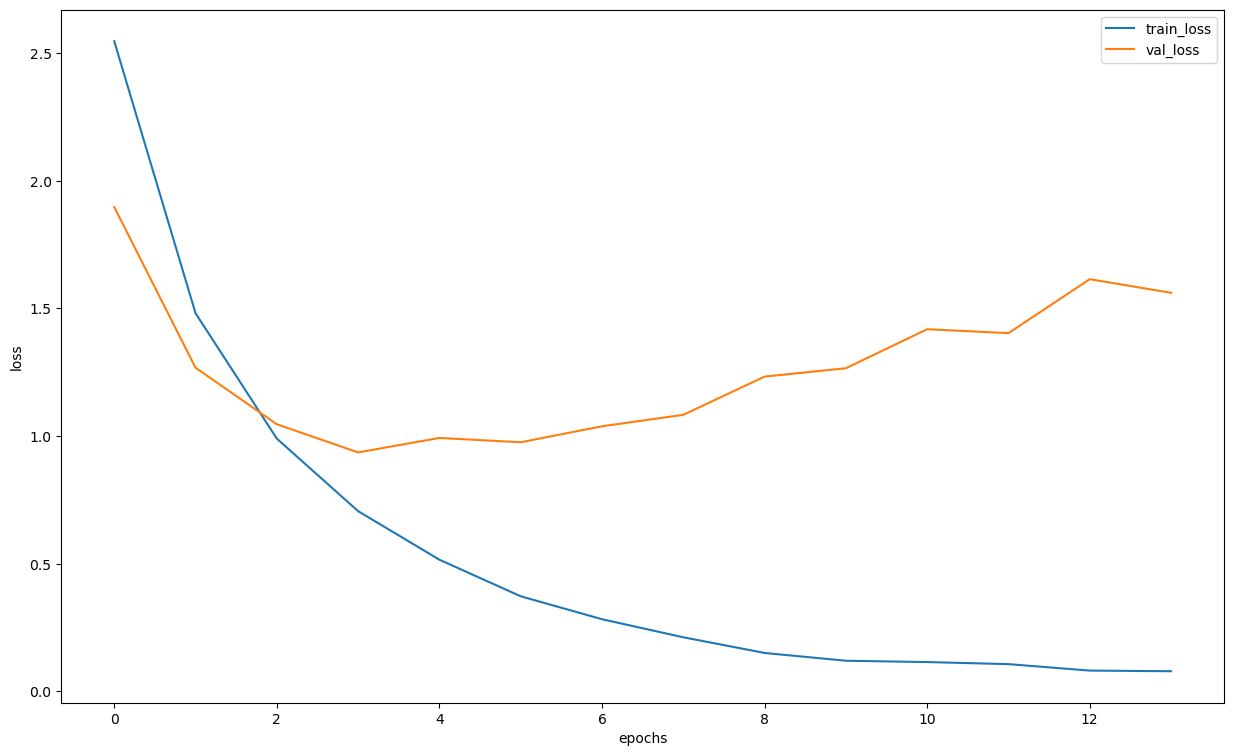

In [30]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Оценка качества модели

In [16]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [32]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [33]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [34]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [35]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [36]:
print(actual_labels)
y_pred

[2, 2, 4, 0, 2, 2, 6, 4, 0, 0, 6, 0, 4, 3, 0, 4, 6, 0, 4, 4]


array([ 2,  2, 20,  0,  2,  2,  6,  4,  0, 15,  6,  0,  4,  3,  0,  4,  6,
       15, 29,  4])

Вычислим целевую (f1-score) метрику на валидационной выборке.

In [37]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')


0.8000000000000002

Сделаем визуализацию, чтобы посмотреть насколько сеть уверена в своих ответах.

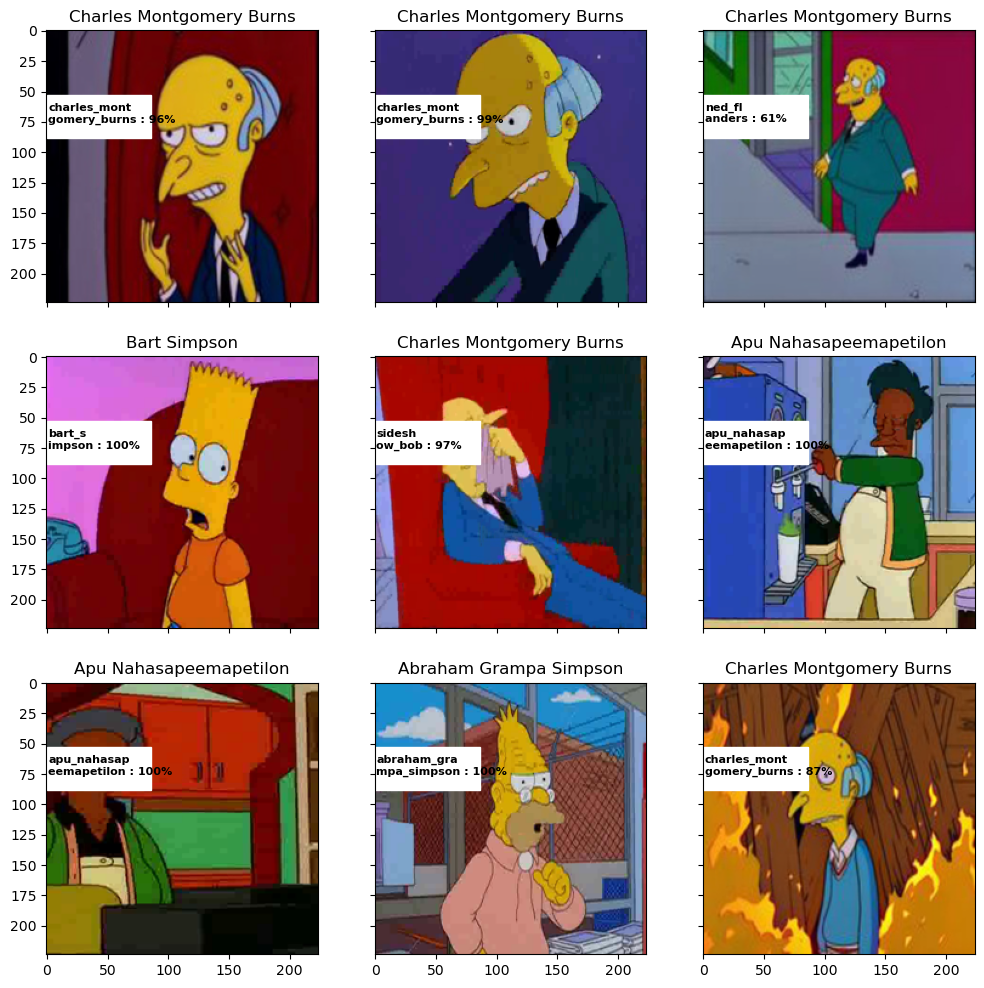

In [38]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit на Kaggle

In [41]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [42]:
import pandas as pd
#my_submit = pd.read_csv("gdrive/My Drive/sample_submission.csv")
my_submit = pd.read_csv("/kaggle/input/journey-springfield/sample_submission.csv")
# my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [43]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [44]:
my_submit.to_csv('/kaggle/working/simple_cnn_baseline.csv', index=False)

Данная архитектура на 2 эпохах тренировки показала результат на тесте (на кагле) 0.67056

Данная архитектура при повышении количества эпох обучения до 14 показала результат на тесте (на кагле) 0.94367
При этом, глядя на график, начиная с третьей эпохи на валидационной выборке лосс начинает расти, что говорит о переобучении. На самом деле результат на тесте не должен быть таким высоким. Можно сделать вывод, что тестовая выборка очень похожа на трейновую. Далее поэкспериментируем с архитектурами и постараемся достичь ещё более высокого скора на тесте.

## 2. Улучшенная архитектура

**Построение новой архитектуры**

Для начала попробуем использовать ту же (пусть и простую) архитектуру, но добавим батчнорм-ы и дропаут-ы, а также увеличим количество полносвязных слоёв. Однако батчнорм и дропаут вместе использовать не желательно, если и спользовать, то сначала батчнорм, а потом дропаут.
Попроубем использовать батчнорм в свёрточных слоях, а дропаут - в полносвязных.

In [51]:
class UpgradedCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.bn5 = nn.BatchNorm2d(96)
        self.fc1 = nn.Linear(96 * 5 * 5, 1000)
        self.dropout1 = nn.Dropout(p = 0.7)
        self.fc2 = nn.Linear(1000, 600)
        self.dropout2 = nn.Dropout(p = 0.5)
        self.fc3 = nn.Linear(600, 200)
        self.out = nn.Linear(200, n_classes)
  
  
    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = self.bn2(self.conv2(x))
        x = self.bn3(self.conv3(x))
        x = self.bn4(self.conv4(x))
        x = self.bn5(self.conv5(x))

        x = x.view(x.size(0), -1)
        x = self.dropout1(nn.functional.relu(self.fc1(x)))
        x = self.dropout2(nn.functional.relu(self.fc2(x)))
        x = nn.functional.relu(self.fc3(x))
        logits = self.out(x)
        return logits

In [52]:
model = UpgradedCnn(n_classes).to(DEVICE)
print(model)

UpgradedCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, c

### Обучение сети

In [53]:
history = train(train_dataset, val_dataset, model = model, epochs=15, batch_size=64)

epoch:   7%|▋         | 1/15 [02:39<37:09, 159.23s/it]


Epoch 001 train_loss: 2.1520     val_loss 1.4795 train_acc 0.4121 val_acc 0.5902


epoch:  13%|█▎        | 2/15 [05:17<34:18, 158.37s/it]


Epoch 002 train_loss: 1.1134     val_loss 0.9366 train_acc 0.6905 val_acc 0.7298


epoch:  20%|██        | 3/15 [07:53<31:29, 157.43s/it]


Epoch 003 train_loss: 0.7143     val_loss 0.8001 train_acc 0.7929 val_acc 0.7879


epoch:  27%|██▋       | 4/15 [10:27<28:38, 156.27s/it]


Epoch 004 train_loss: 0.4927     val_loss 0.7140 train_acc 0.8568 val_acc 0.8088


epoch:  33%|███▎      | 5/15 [13:03<26:01, 156.16s/it]


Epoch 005 train_loss: 0.3518     val_loss 0.8152 train_acc 0.8969 val_acc 0.8015


epoch:  40%|████      | 6/15 [15:40<23:25, 156.19s/it]


Epoch 006 train_loss: 0.2427     val_loss 0.7555 train_acc 0.9280 val_acc 0.8181


epoch:  47%|████▋     | 7/15 [18:16<20:50, 156.37s/it]


Epoch 007 train_loss: 0.2002     val_loss 0.8021 train_acc 0.9401 val_acc 0.8126


epoch:  53%|█████▎    | 8/15 [20:53<18:15, 156.56s/it]


Epoch 008 train_loss: 0.1382     val_loss 0.9300 train_acc 0.9578 val_acc 0.8135


epoch:  60%|██████    | 9/15 [23:28<15:36, 156.14s/it]


Epoch 009 train_loss: 0.1431     val_loss 0.9660 train_acc 0.9581 val_acc 0.8130


epoch:  67%|██████▋   | 10/15 [26:05<13:01, 156.22s/it]


Epoch 010 train_loss: 0.1224     val_loss 0.9119 train_acc 0.9648 val_acc 0.8315


epoch:  73%|███████▎  | 11/15 [28:41<10:25, 156.29s/it]


Epoch 011 train_loss: 0.1320     val_loss 0.9119 train_acc 0.9610 val_acc 0.8246


epoch:  80%|████████  | 12/15 [31:19<07:50, 156.72s/it]


Epoch 012 train_loss: 0.0948     val_loss 1.0588 train_acc 0.9739 val_acc 0.8093


epoch:  87%|████████▋ | 13/15 [33:58<05:14, 157.30s/it]


Epoch 013 train_loss: 0.0570     val_loss 0.9247 train_acc 0.9838 val_acc 0.8429


epoch:  93%|█████████▎| 14/15 [36:41<02:39, 159.23s/it]


Epoch 014 train_loss: 0.0774     val_loss 0.9694 train_acc 0.9780 val_acc 0.8305


epoch: 100%|██████████| 15/15 [39:23<00:00, 157.56s/it]


Epoch 015 train_loss: 0.0664     val_loss 1.0688 train_acc 0.9822 val_acc 0.8185


### Считаем метрику на валидационной выборке

In [24]:
from sklearn.metrics import f1_score

def val_f1_score(model, sample_number = 20):
  idxs = list(map(int, np.random.uniform(0,1000, sample_number)))
  imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

  probs_ims = predict(model, imgs)

  y_pred = np.argmax(probs_ims,-1)

  actual_labels = [val_dataset[id][1] for id in idxs]

  return f1_score(actual_labels, y_pred, average='micro')

In [56]:
val_f1_score(model, 100)

0.85

### Строим кривые обучения

In [18]:
def train_curves(history):
  loss, acc, val_loss, val_acc = zip(*history)
  plt.figure(figsize=(15, 9))
  plt.plot(loss, label="train_loss")
  plt.plot(val_loss, label="val_loss")
  plt.legend(loc='best')
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.show()

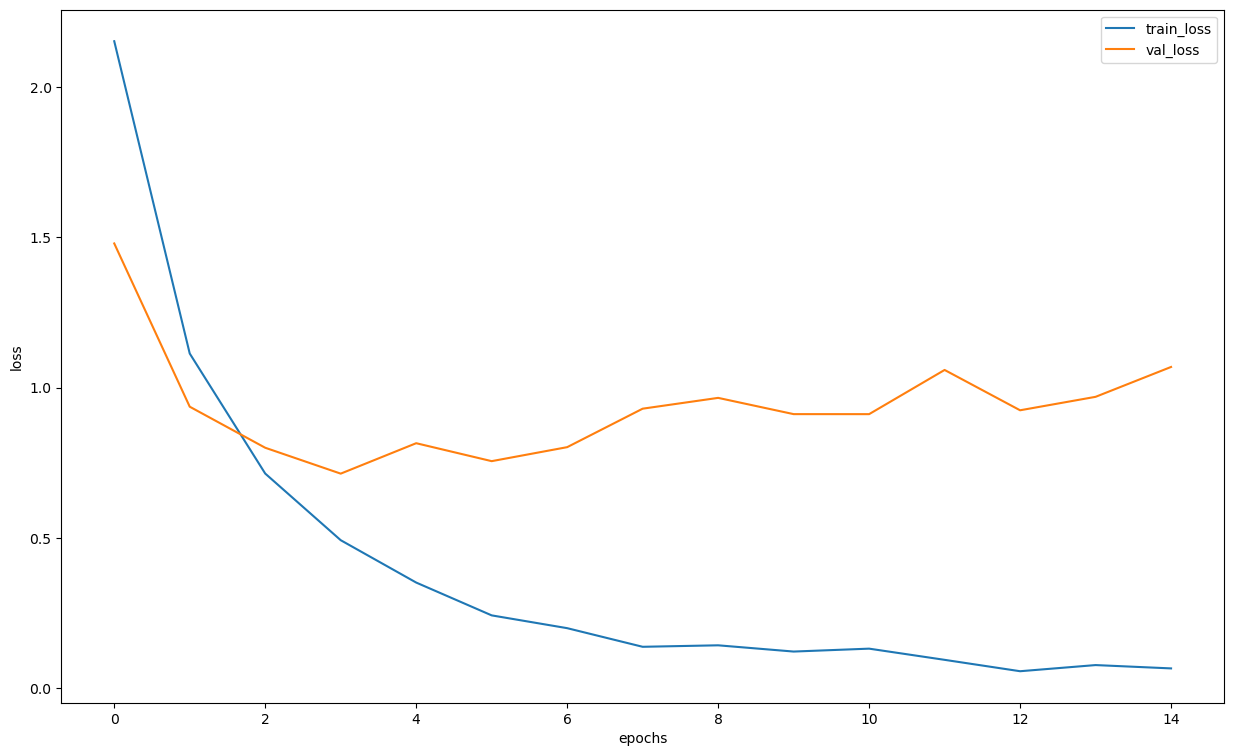

In [58]:
train_curves(history)

### Посылка на Kaggle

In [19]:
def create_submission(model, filename):
  test_dataset = SimpsonsDataset(test_files, mode="test")
  test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
  probs = predict(model, test_loader)

  label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
  
  preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
  test_filenames = [path.name for path in test_dataset.files]

  import pandas as pd
  my_submit = pd.read_csv("/kaggle/input/journey-springfield/sample_submission.csv")

  my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

  my_submit.to_csv('/kaggle/working/' + filename + '.csv', index=False)

In [60]:
create_submission(model, 'BN_DROPOUT_V1')

Результат на Kaggle - 0.94261, что немного ниже, чем базовая модель. Вероятно, стоило более аккуратно поработать с learning rate-ом.

## 3. Transfer Learning

Воспользуемся уже обуенными нейросетями. Для начала, установим Alexnet, заменим последний слой-классификатор и "заморозим" свёрточные слои. Обучать будем только новый классификатор.

In [20]:
import torchvision.models as models

model = models.alexnet(pretrained = True)#.to(DEVICE)
model

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [21]:
# замораживаем параметры (веса)
for param in model.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
n_classes = len(np.unique(train_val_labels))
model.classifier = nn.Linear(num_features, n_classes)


In [22]:
model = model.cuda()
history = train(train_dataset, val_dataset, model = model, epochs=15, batch_size=64, lr=1e-4)


epoch:   7%|▋         | 1/15 [05:22<1:15:16, 322.62s/it]


Epoch 001 train_loss: 1.7161     val_loss 1.0513 train_acc 0.5598 val_acc 0.7354


epoch:  13%|█▎        | 2/15 [07:57<48:33, 224.14s/it]  


Epoch 002 train_loss: 0.6707     val_loss 0.8632 train_acc 0.8346 val_acc 0.7784


epoch:  20%|██        | 3/15 [10:32<38:30, 192.51s/it]


Epoch 003 train_loss: 0.4226     val_loss 0.7850 train_acc 0.9053 val_acc 0.7977


epoch:  27%|██▋       | 4/15 [13:06<32:30, 177.30s/it]


Epoch 004 train_loss: 0.2910     val_loss 0.7390 train_acc 0.9437 val_acc 0.8122


epoch:  33%|███▎      | 5/15 [15:40<28:09, 168.97s/it]


Epoch 005 train_loss: 0.2119     val_loss 0.7246 train_acc 0.9666 val_acc 0.8170


epoch:  40%|████      | 6/15 [18:15<24:38, 164.23s/it]


Epoch 006 train_loss: 0.1573     val_loss 0.7104 train_acc 0.9802 val_acc 0.8179


epoch:  47%|████▋     | 7/15 [20:50<21:28, 161.09s/it]


Epoch 007 train_loss: 0.1204     val_loss 0.7153 train_acc 0.9883 val_acc 0.8200


epoch:  53%|█████▎    | 8/15 [23:25<18:33, 159.00s/it]


Epoch 008 train_loss: 0.0932     val_loss 0.7152 train_acc 0.9938 val_acc 0.8252


epoch:  60%|██████    | 9/15 [25:58<15:44, 157.37s/it]


Epoch 009 train_loss: 0.0747     val_loss 0.7145 train_acc 0.9969 val_acc 0.8225


epoch:  67%|██████▋   | 10/15 [28:32<13:00, 156.17s/it]


Epoch 010 train_loss: 0.0601     val_loss 0.7188 train_acc 0.9980 val_acc 0.8227


epoch:  73%|███████▎  | 11/15 [31:06<10:22, 155.69s/it]


Epoch 011 train_loss: 0.0488     val_loss 0.7210 train_acc 0.9989 val_acc 0.8237


epoch:  87%|████████▋ | 13/15 [36:14<05:09, 154.71s/it]


Epoch 013 train_loss: 0.0338     val_loss 0.7204 train_acc 0.9997 val_acc 0.8258


epoch:  93%|█████████▎| 14/15 [38:50<02:35, 155.09s/it]


Epoch 014 train_loss: 0.0289     val_loss 0.7233 train_acc 0.9997 val_acc 0.8298


epoch: 100%|██████████| 15/15 [41:23<00:00, 165.60s/it]


Epoch 015 train_loss: 0.0243     val_loss 0.7233 train_acc 0.9999 val_acc 0.8284


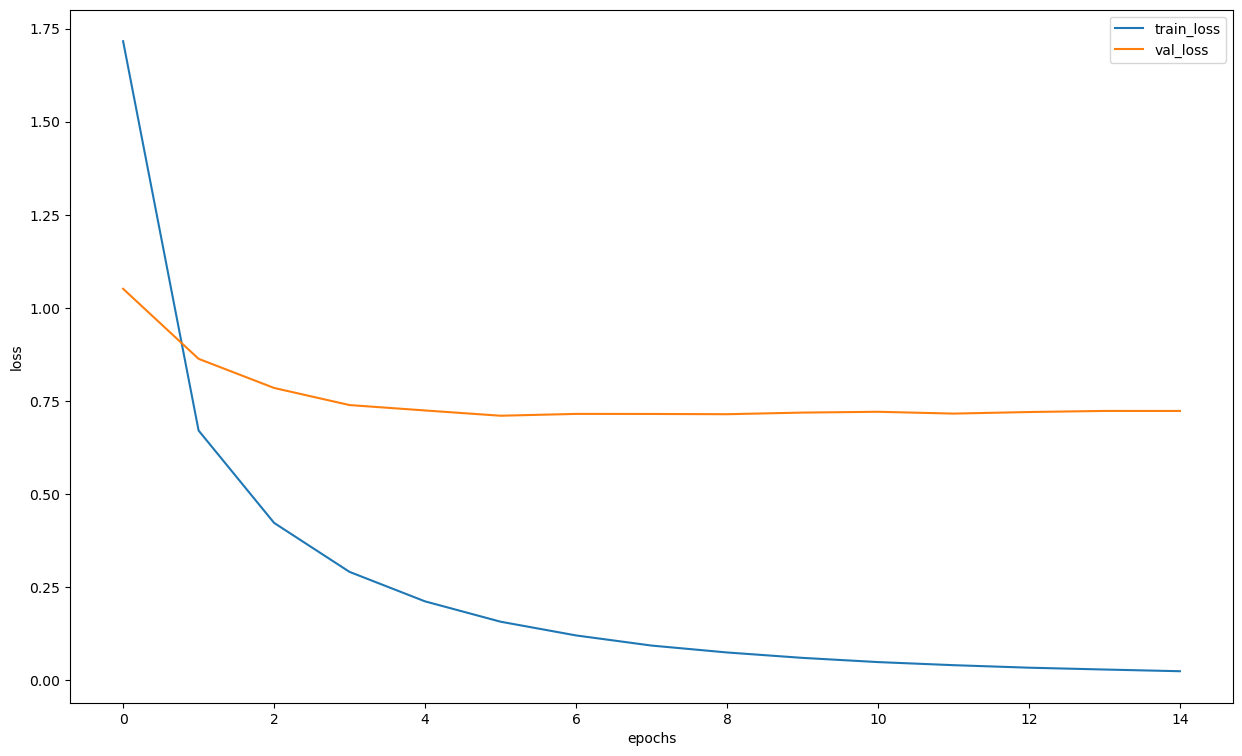

0.79

In [25]:
train_curves(history)
val_f1_score(model, 100)

In [26]:
create_submission(model, 'ALEXNET_AS_FE')

**Результат на Kaggle:** 0.94473. Уже лучше, чем базовая модель.

Попробуем использовать что-то помощнее AlexNet-а.

In [27]:
model = models.efficientnet_b0(pretrained = True)
model

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Заменим классификатор на свой и обучим его.

In [28]:
# замораживаем параметры (веса)
for param in model.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 1280
# Заменяем Fully-Connected слой на наш линейный классификатор
n_classes = len(np.unique(train_val_labels))
model.classifier = nn.Linear(num_features, n_classes)


In [29]:
history = train(train_dataset, val_dataset, model = model.cuda(), epochs=15, batch_size=64, lr=1e-4)

epoch:   7%|▋         | 1/15 [03:02<42:29, 182.13s/it]


Epoch 001 train_loss: 3.1172     val_loss 2.8042 train_acc 0.1687 val_acc 0.2912


epoch:  13%|█▎        | 2/15 [05:52<37:55, 175.07s/it]


Epoch 002 train_loss: 2.5973     val_loss 2.4415 train_acc 0.4319 val_acc 0.5040


epoch:  20%|██        | 3/15 [08:40<34:23, 171.96s/it]


Epoch 003 train_loss: 2.2692     val_loss 2.1772 train_acc 0.5552 val_acc 0.5583


epoch:  27%|██▋       | 4/15 [11:28<31:13, 170.29s/it]


Epoch 004 train_loss: 2.0269     val_loss 1.9818 train_acc 0.6001 val_acc 0.5927


epoch:  33%|███▎      | 5/15 [14:18<28:21, 170.19s/it]


Epoch 005 train_loss: 1.8435     val_loss 1.8336 train_acc 0.6276 val_acc 0.6133


epoch:  40%|████      | 6/15 [17:08<25:31, 170.12s/it]


Epoch 006 train_loss: 1.7006     val_loss 1.7178 train_acc 0.6479 val_acc 0.6292


epoch:  47%|████▋     | 7/15 [19:56<22:35, 169.46s/it]


Epoch 007 train_loss: 1.5854     val_loss 1.6249 train_acc 0.6646 val_acc 0.6423


epoch:  53%|█████▎    | 8/15 [22:43<19:41, 168.74s/it]


Epoch 008 train_loss: 1.4907     val_loss 1.5479 train_acc 0.6779 val_acc 0.6532


epoch:  60%|██████    | 9/15 [25:29<16:47, 168.00s/it]


Epoch 009 train_loss: 1.4104     val_loss 1.4837 train_acc 0.6892 val_acc 0.6603


epoch:  67%|██████▋   | 10/15 [28:16<13:57, 167.59s/it]


Epoch 010 train_loss: 1.3415     val_loss 1.4285 train_acc 0.7011 val_acc 0.6714


epoch:  73%|███████▎  | 11/15 [31:03<11:08, 167.25s/it]


Epoch 011 train_loss: 1.2812     val_loss 1.3809 train_acc 0.7113 val_acc 0.6771


epoch:  80%|████████  | 12/15 [33:50<08:22, 167.37s/it]


Epoch 012 train_loss: 1.2281     val_loss 1.3394 train_acc 0.7208 val_acc 0.6834


epoch:  87%|████████▋ | 13/15 [36:37<05:34, 167.32s/it]


Epoch 013 train_loss: 1.1806     val_loss 1.3033 train_acc 0.7285 val_acc 0.6909


epoch:  93%|█████████▎| 14/15 [39:25<02:47, 167.29s/it]


Epoch 014 train_loss: 1.1380     val_loss 1.2709 train_acc 0.7366 val_acc 0.6943


epoch: 100%|██████████| 15/15 [42:11<00:00, 168.75s/it]


Epoch 015 train_loss: 1.0994     val_loss 1.2421 train_acc 0.7440 val_acc 0.7021


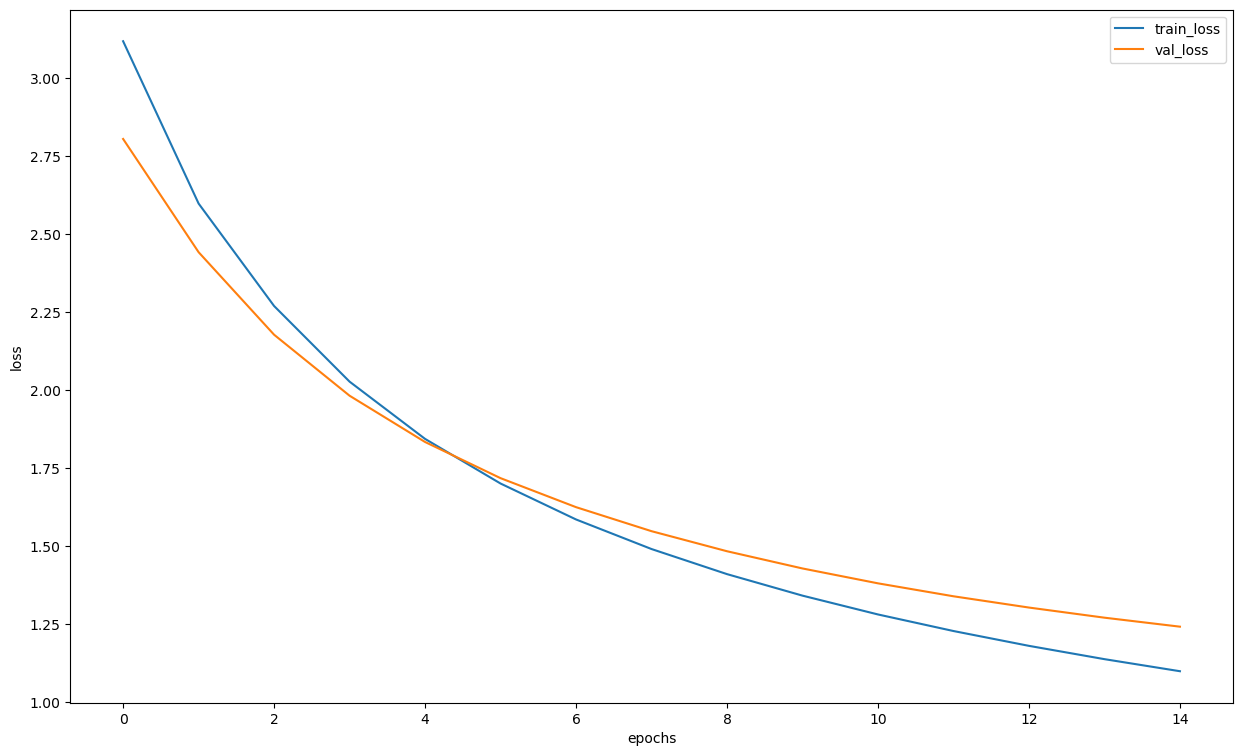

0.65

In [30]:
train_curves(history)
val_f1_score(model, 100)

Дообучим сеть

In [31]:
history = train(train_dataset, val_dataset, model = model.cuda(), epochs=15, batch_size=64, lr=1e-4)

epoch:   7%|▋         | 1/15 [02:47<38:58, 167.06s/it]


Epoch 001 train_loss: 1.0645     val_loss 1.2144 train_acc 0.7498 val_acc 0.7063


epoch:  13%|█▎        | 2/15 [05:30<35:41, 164.76s/it]


Epoch 002 train_loss: 1.0278     val_loss 1.1889 train_acc 0.7573 val_acc 0.7111


epoch:  20%|██        | 3/15 [08:13<32:46, 163.89s/it]


Epoch 003 train_loss: 0.9965     val_loss 1.1662 train_acc 0.7641 val_acc 0.7128


epoch:  27%|██▋       | 4/15 [10:58<30:08, 164.38s/it]


Epoch 004 train_loss: 0.9677     val_loss 1.1461 train_acc 0.7707 val_acc 0.7207


epoch:  33%|███▎      | 5/15 [13:45<27:35, 165.50s/it]


Epoch 005 train_loss: 0.9413     val_loss 1.1279 train_acc 0.7765 val_acc 0.7224


epoch:  40%|████      | 6/15 [16:32<24:52, 165.88s/it]


Epoch 006 train_loss: 0.9169     val_loss 1.1117 train_acc 0.7820 val_acc 0.7262


epoch:  47%|████▋     | 7/15 [19:18<22:09, 166.13s/it]


Epoch 007 train_loss: 0.8942     val_loss 1.0966 train_acc 0.7863 val_acc 0.7304


epoch:  53%|█████▎    | 8/15 [22:05<19:24, 166.42s/it]


Epoch 008 train_loss: 0.8731     val_loss 1.0825 train_acc 0.7918 val_acc 0.7331


epoch:  60%|██████    | 9/15 [24:52<16:38, 166.40s/it]


Epoch 009 train_loss: 0.8533     val_loss 1.0699 train_acc 0.7969 val_acc 0.7350


epoch:  67%|██████▋   | 10/15 [27:35<13:46, 165.33s/it]


Epoch 010 train_loss: 0.8346     val_loss 1.0579 train_acc 0.8004 val_acc 0.7379


epoch:  73%|███████▎  | 11/15 [30:16<10:55, 163.96s/it]


Epoch 011 train_loss: 0.8171     val_loss 1.0473 train_acc 0.8058 val_acc 0.7413


epoch:  80%|████████  | 12/15 [32:59<08:11, 163.81s/it]


Epoch 012 train_loss: 0.8006     val_loss 1.0364 train_acc 0.8085 val_acc 0.7434


epoch:  87%|████████▋ | 13/15 [35:42<05:27, 163.50s/it]


Epoch 013 train_loss: 0.7846     val_loss 1.0277 train_acc 0.8130 val_acc 0.7421


epoch:  93%|█████████▎| 14/15 [38:25<02:43, 163.36s/it]


Epoch 014 train_loss: 0.7697     val_loss 1.0185 train_acc 0.8170 val_acc 0.7465


epoch: 100%|██████████| 15/15 [41:08<00:00, 164.55s/it]


Epoch 015 train_loss: 0.7553     val_loss 1.0100 train_acc 0.8199 val_acc 0.7476


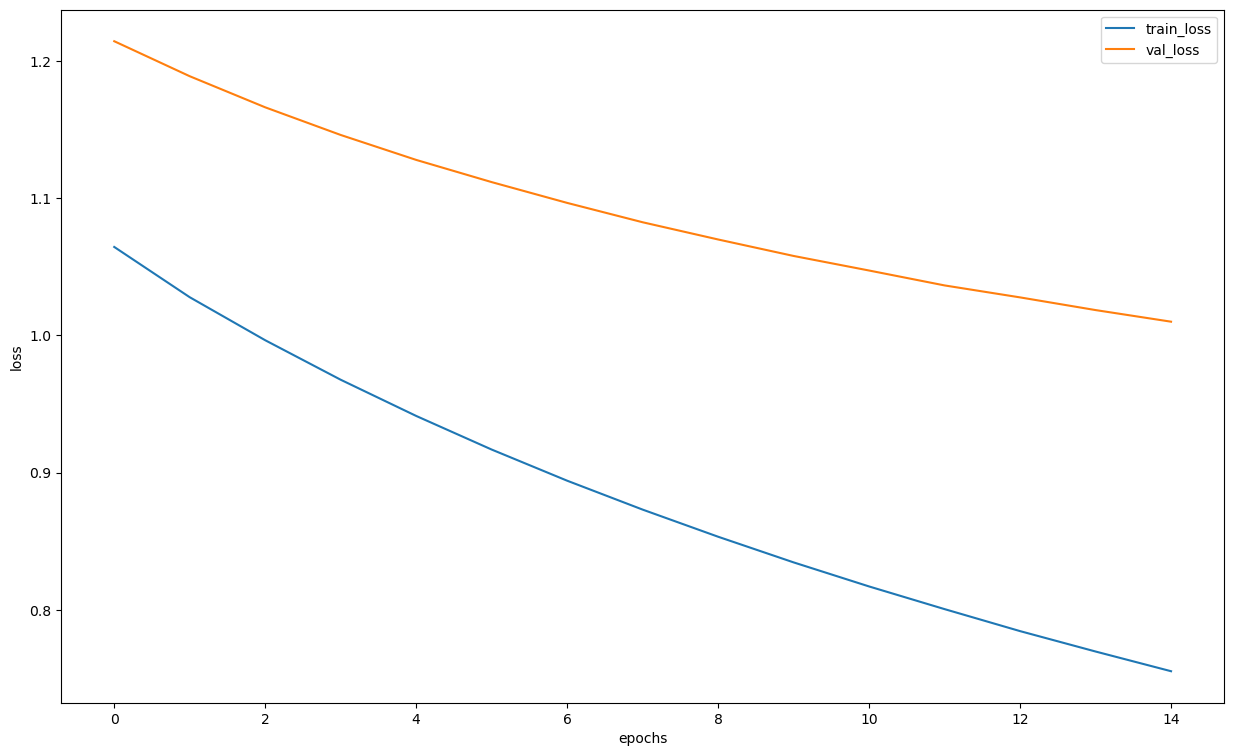

0.78

In [32]:
train_curves(history)
val_f1_score(model, 100)

In [33]:
create_submission(model, 'EFFICIENT_NET_AS_FE_V1')

Посылка на кагл показала плохой результат в 0.75

Попробуем разморозить несколько последних слоёв и обучить модель заново.

In [38]:
model = models.efficientnet_b0(pretrained = True)


In [39]:
# замораживаем параметры (веса) кроме последних 3
for param in model.features[:-3].parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 1280
# Заменяем Fully-Connected слой на наш линейный классификатор
n_classes = len(np.unique(train_val_labels))
model.classifier = nn.Linear(num_features, n_classes)

In [40]:
history = train(train_dataset, val_dataset, model = model.cuda(), epochs=10, batch_size=128, lr = 1e-4)

epoch:  10%|█         | 1/10 [02:55<26:15, 175.01s/it]


Epoch 001 train_loss: 2.2933     val_loss 0.9486 train_acc 0.5305 val_acc 0.7858


epoch:  20%|██        | 2/10 [05:48<23:11, 173.88s/it]


Epoch 002 train_loss: 0.5453     val_loss 0.3908 train_acc 0.8679 val_acc 0.9033


epoch:  30%|███       | 3/10 [08:41<20:15, 173.65s/it]


Epoch 003 train_loss: 0.2062     val_loss 0.3020 train_acc 0.9471 val_acc 0.9266


epoch:  40%|████      | 4/10 [11:34<17:21, 173.53s/it]


Epoch 004 train_loss: 0.0714     val_loss 0.3192 train_acc 0.9831 val_acc 0.9324


epoch:  50%|█████     | 5/10 [14:28<14:27, 173.53s/it]


Epoch 005 train_loss: 0.0246     val_loss 0.3584 train_acc 0.9952 val_acc 0.9326


epoch:  60%|██████    | 6/10 [17:20<11:31, 172.98s/it]


Epoch 006 train_loss: 0.0158     val_loss 0.4407 train_acc 0.9963 val_acc 0.9324


epoch:  70%|███████   | 7/10 [20:13<08:39, 173.22s/it]


Epoch 007 train_loss: 0.0173     val_loss 0.4565 train_acc 0.9955 val_acc 0.9207


epoch:  80%|████████  | 8/10 [23:07<05:46, 173.34s/it]


Epoch 008 train_loss: 0.0056     val_loss 0.3879 train_acc 0.9989 val_acc 0.9396


epoch:  90%|█████████ | 9/10 [26:00<02:53, 173.26s/it]


Epoch 009 train_loss: 0.0009     val_loss 0.4303 train_acc 0.9999 val_acc 0.9379


epoch: 100%|██████████| 10/10 [28:54<00:00, 173.43s/it]


Epoch 010 train_loss: 0.0005     val_loss 0.4510 train_acc 0.9999 val_acc 0.9377


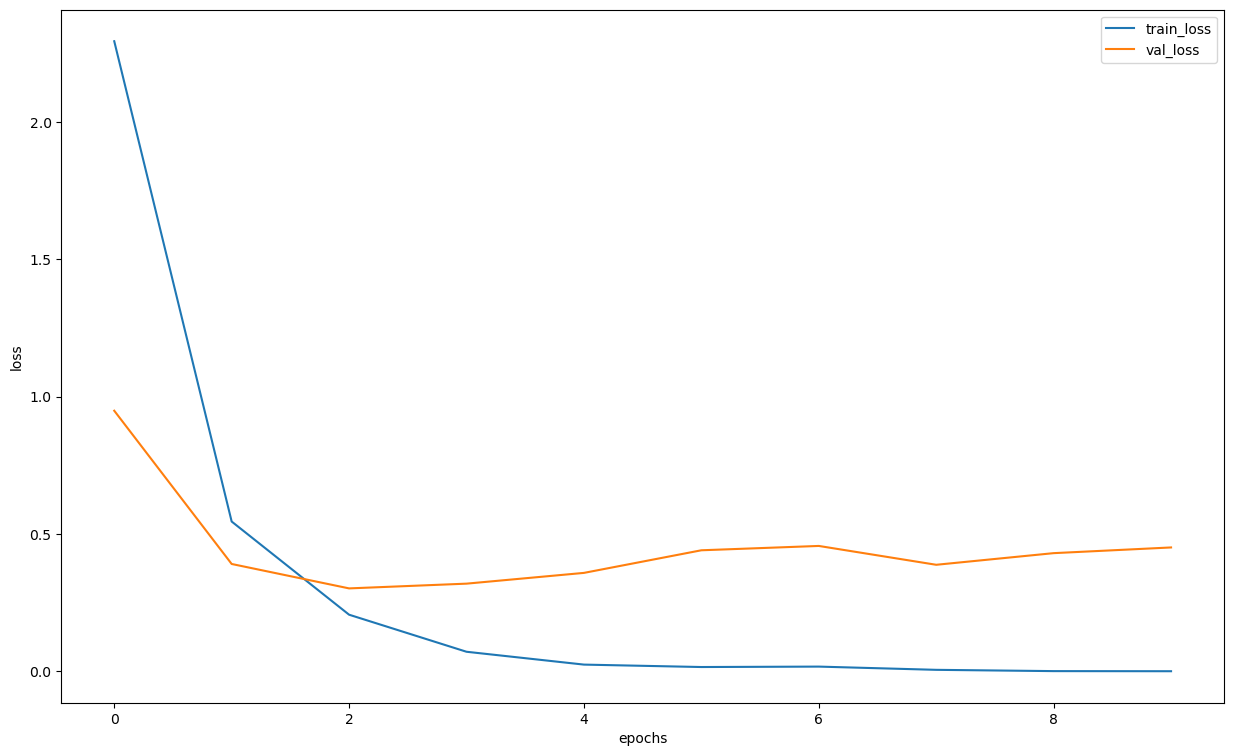

0.97

In [41]:
train_curves(history)
val_f1_score(model, 100)

In [42]:
create_submission(model, 'EFFICIENT_NET_AS_FE_V2')

Этот сабмит получил почти 0.97

Попробуем добиться наилучшего результата, используя EfficientNet_b2

In [14]:
model = models.efficientnet_b2(pretrained = True)
model

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


  0%|          | 0.00/35.2M [00:00<?, ?B/s]

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [15]:
for param in model.features[:-3].parameters():
    param.requires_grad = False

n_classes = len(np.unique(train_val_labels))
model.classifier = nn.Sequential(
    nn.Linear(in_features = 1408, out_features = 1000),
    nn.ReLU(),
    nn.Linear(in_features = 1000, out_features = 1000),
    nn.ReLU(),
    nn.Linear(in_features = 1000, out_features = n_classes)
)

In [16]:
history = train(train_dataset, val_dataset, model = model.cuda(), epochs=15, batch_size=128, lr = 1e-4)

epoch:   7%|▋         | 1/15 [04:22<1:01:12, 262.32s/it]


Epoch 001 train_loss: 1.9743     val_loss 0.6941 train_acc 0.5199 val_acc 0.8271


epoch:  13%|█▎        | 2/15 [07:33<47:44, 220.34s/it]  


Epoch 002 train_loss: 0.4137     val_loss 0.3458 train_acc 0.8894 val_acc 0.9138


epoch:  20%|██        | 3/15 [10:39<40:57, 204.79s/it]


Epoch 003 train_loss: 0.1274     val_loss 0.3304 train_acc 0.9657 val_acc 0.9316


epoch:  27%|██▋       | 4/15 [13:45<36:12, 197.48s/it]


Epoch 004 train_loss: 0.0370     val_loss 0.3990 train_acc 0.9901 val_acc 0.9308


epoch:  33%|███▎      | 5/15 [16:53<32:20, 194.07s/it]


Epoch 005 train_loss: 0.0266     val_loss 0.3862 train_acc 0.9931 val_acc 0.9343


epoch:  40%|████      | 6/15 [19:58<28:38, 190.97s/it]


Epoch 006 train_loss: 0.0086     val_loss 0.5094 train_acc 0.9982 val_acc 0.9345


epoch:  47%|████▋     | 7/15 [23:04<25:13, 189.23s/it]


Epoch 007 train_loss: 0.0187     val_loss 0.4204 train_acc 0.9947 val_acc 0.9295


epoch:  53%|█████▎    | 8/15 [26:12<22:01, 188.77s/it]


Epoch 008 train_loss: 0.0097     val_loss 0.4406 train_acc 0.9975 val_acc 0.9362


epoch:  60%|██████    | 9/15 [29:18<18:48, 188.13s/it]


Epoch 009 train_loss: 0.0080     val_loss 0.4236 train_acc 0.9977 val_acc 0.9316


epoch:  67%|██████▋   | 10/15 [32:25<15:37, 187.53s/it]


Epoch 010 train_loss: 0.0098     val_loss 0.3965 train_acc 0.9969 val_acc 0.9371


epoch:  73%|███████▎  | 11/15 [35:31<12:29, 187.31s/it]


Epoch 011 train_loss: 0.0049     val_loss 0.4586 train_acc 0.9985 val_acc 0.9368


epoch:  80%|████████  | 12/15 [38:39<09:22, 187.40s/it]


Epoch 012 train_loss: 0.0009     val_loss 0.4603 train_acc 0.9997 val_acc 0.9450


epoch:  87%|████████▋ | 13/15 [41:42<06:12, 186.13s/it]


Epoch 013 train_loss: 0.0004     val_loss 0.4642 train_acc 0.9999 val_acc 0.9442


epoch:  93%|█████████▎| 14/15 [44:45<03:05, 185.22s/it]


Epoch 014 train_loss: 0.0003     val_loss 0.4631 train_acc 0.9999 val_acc 0.9450


epoch: 100%|██████████| 15/15 [47:49<00:00, 191.29s/it]


Epoch 015 train_loss: 0.0002     val_loss 0.4730 train_acc 0.9999 val_acc 0.9455


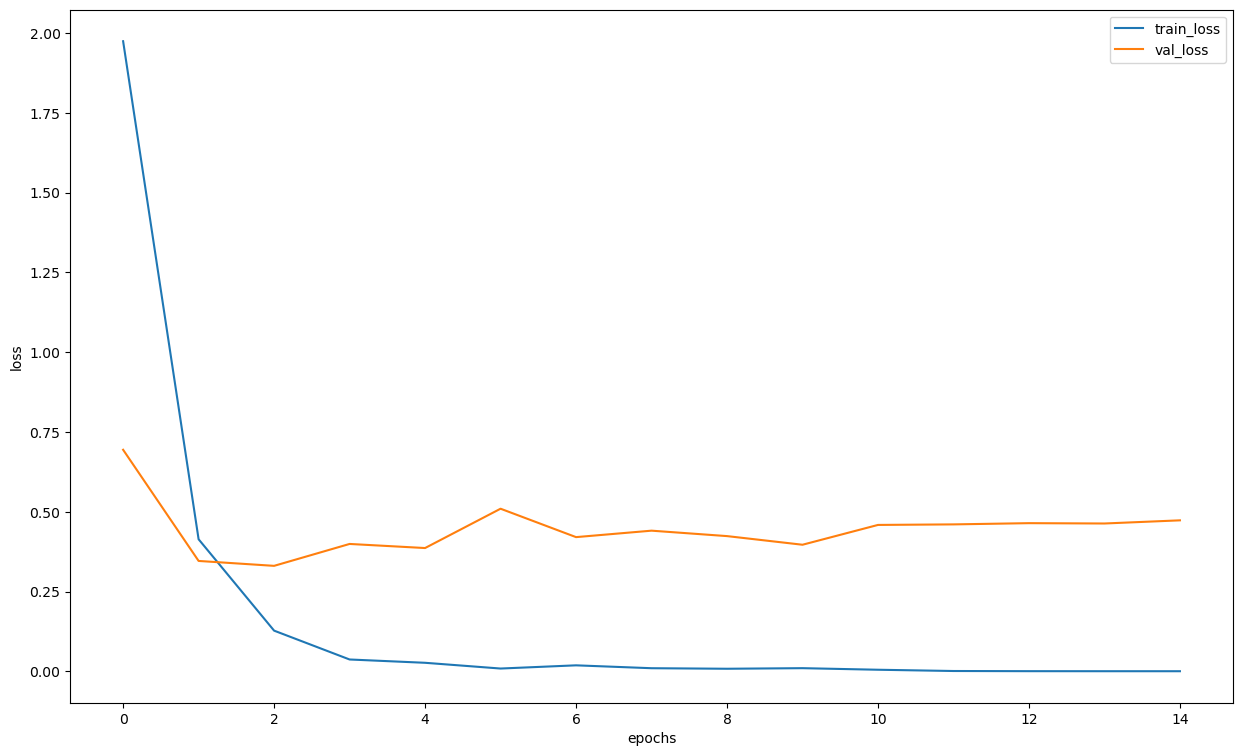

0.91

In [17]:
train_curves(history)
val_f1_score(model, 100)

In [18]:
create_submission(model, 'EFFICIENT_NET_B2_AS_FE')

Результат этой посылки - 0.979
Вполне достаточно.
Для более высоко результата можно было поработать с данными (добавить аугментацию и убрать ошибки в данных), ведь классы не сбалансированы и в них есть ошибки.